In [1]:
import numpy as np
from matplotlib import pyplot as plt
import healpy as hp
import re
from scipy.interpolate import RegularGridInterpolator as interp2d

In [2]:
phi=np.linspace(0,360,361)
tht=np.linspace(0,90,91)
grid=np.deg2rad(np.meshgrid(phi,tht))
pixnums=hp.ang2pix(128,grid[1], grid[0])

In [3]:
pixnums

array([[    0,     0,     0, ...,     3,     3,     0],
       [   12,    12,    12, ...,    23,    23,    12],
       [   60,    60,    60, ...,    83,    83,    60],
       ...,
       [94464, 94977, 94467, ..., 94973, 95486, 94464],
       [96512, 96001, 96515, ..., 97021, 96510, 96512],
       [97536, 98049, 98050, ..., 98557, 98558, 97536]])

In [4]:
np.meshgrid(phi,tht)

(array([[  0.,   1.,   2., ..., 358., 359., 360.],
        [  0.,   1.,   2., ..., 358., 359., 360.],
        [  0.,   1.,   2., ..., 358., 359., 360.],
        ...,
        [  0.,   1.,   2., ..., 358., 359., 360.],
        [  0.,   1.,   2., ..., 358., 359., 360.],
        [  0.,   1.,   2., ..., 358., 359., 360.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        ...,
        [88., 88., 88., ..., 88., 88., 88.],
        [89., 89., 89., ..., 89., 89., 89.],
        [90., 90., 90., ..., 90., 90., 90.]]))

In [5]:
with open("/home/mohan/Projects/fee-analysis/beam_nec_sims/horgain.txt") as f:
    lines=f.readlines()

In [6]:
horbeam=np.zeros((91,361),dtype='float64')

In [7]:
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
rx = re.compile(numeric_const_pattern, re.VERBOSE)

In [8]:
xx=''.join(lines)
yy=xx.split('\n\n')[:91]
for lth in yy:
    laz=lth.split('\n')
    for l in laz:
        nums=rx.findall(l)
        nums=[float(m) for m in nums]
        azimuth=int(nums[0])
        za=int(nums[1])
        # print(azimuth,za,nums[2])
        gain=10**(nums[2]/10)
        horbeam[np.abs(za),azimuth]=gain

In [9]:
NSIDE=256
NPIX=hp.nside2npix(NSIDE)
RES=hp.nside2resol(NSIDE,arcmin=True)
print(NPIX,RES)

786432 13.741945647269624


In [10]:
horbeam_hp=np.zeros(NPIX,dtype='float64')
pix_count=horbeam_hp.copy()

In [11]:
for i in range(91):
    for j in range(361):
        pix_count[pixnums[i,j]]+=1
        horbeam_hp[pixnums[i,j]]+=horbeam[i,j]
horbeam_hp/=pix_count

/tmp/ipykernel_1775808/1463854975.py:5: RuntimeWarning: invalid value encountered in divide
  horbeam_hp/=pix_count


In [12]:
mytht,myphi=hp.pix2ang(NSIDE,np.arange(0,NPIX))

In [13]:
idx_above_hor=mytht<=np.pi/2

In [14]:
interpobj=interp2d((np.deg2rad(tht),np.deg2rad(phi)),horbeam,method='cubic')

In [15]:
mytht_above_hor=mytht[idx_above_hor].copy()
myphi_above_hor=myphi[idx_above_hor].copy()

In [16]:
coords=np.zeros((len(mytht_above_hor),2),dtype='float64')
coords[:,0]=mytht_above_hor
coords[:,1]=myphi_above_hor

In [17]:
horbeam_hp=np.zeros(NPIX,dtype='float64')

In [18]:
horbeam_hp[~idx_above_hor]=np.nan
horbeam_hp

array([ 0.,  0.,  0., ..., nan, nan, nan])

In [19]:
horbeam_hp[idx_above_hor]=interpobj(coords)

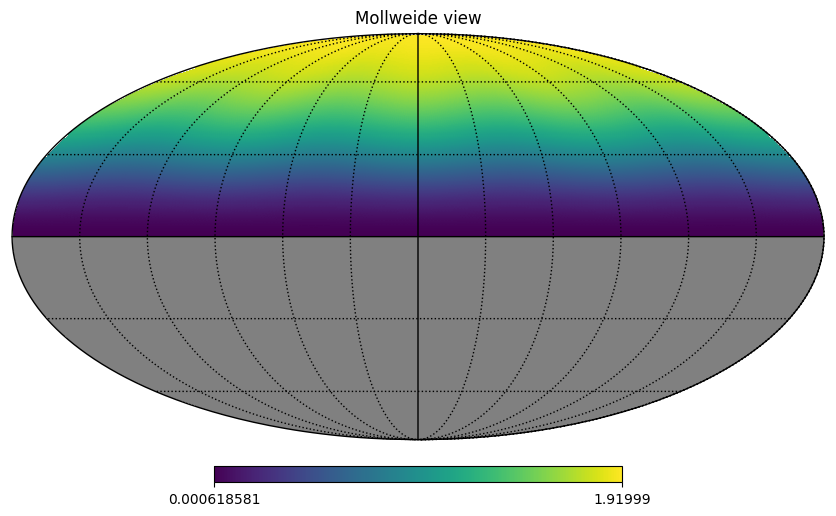

In [20]:
hp.mollview(horbeam_hp)
hp.graticule()

In [21]:
np.nansum(horbeam_hp)*hp.nside2pixarea(NSIDE)/(np.pi*4)

np.float64(0.4333927636655583)

In [22]:
np.nansum(horbeam_hp)*hp.nside2pixarea(NSIDE)

np.float64(5.446174089802781)

In [23]:
2*np.pi

6.283185307179586

In [38]:
mytht[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)].shape
horbeam_hp[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)].shape

(101,)

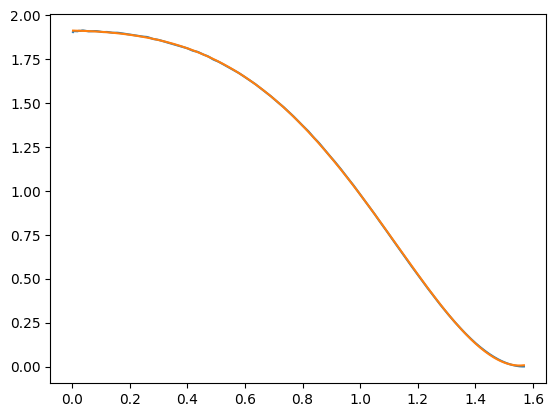

In [53]:
theta_slice = np.linspace(0,np.pi/2,1001)
beam_max = np.max(horbeam_hp[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)])
plt.plot(mytht[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)], horbeam_hp[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)])
m=np.polyfit(mytht[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)], horbeam_hp[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)],5)
plt.plot(mytht[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)], np.polyval(m,mytht[hp.pixelfunc.ang2pix(NSIDE,theta_slice,0)]))


In [54]:
m

array([ 0.59647504, -1.06055331, -0.01000106, -0.43683787, -0.0227381 ,
        1.91318984])

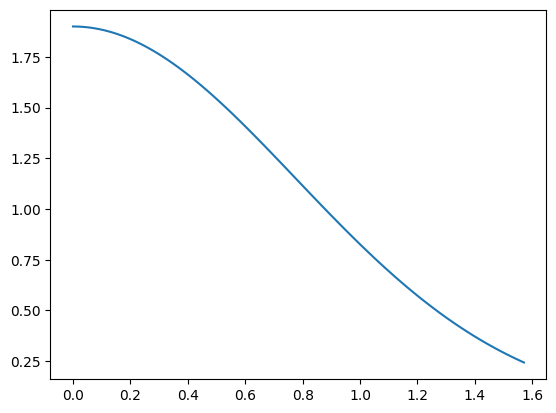

In [48]:
plt.plot(theta_slice, 1.9*np.exp(-theta_slice**2/1.2))